# XGBoost

In [1]:
# warningの無視
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 
import os
import datetime
import pickle

# base
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta

# visualize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# model
import xgboost as xgb
# https://qiita.com/FJyusk56/items/0649f4362587261bd57a

from sklearn.model_selection import train_test_split

# 評価指標
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score # 精度の確認 / 正解率
from sklearn.metrics import f1_score       #f1

# from hyperopt import fmin
# from hyperopt import tpe
# from hyperopt import hp
# from hyperopt import STATUS_OK
# from hyperopt import Trials

In [1]:
# User defined functions
from self_lib import tips
from self_lib import doggie_tail as d_
from self_lib import timer as t

# Jupyter上で図を表示するためのコマンド
%matplotlib inline

ModuleNotFoundError: No module named 'self_lib'

In [ ]:
# 表示列数を指定
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 100)

### version setting

In [ ]:
submitVer="_v05"
modelName="XGBoost"

In [ ]:
featureName="All"

In [2]:
yName='LoanStatus'

In [3]:
# y
fileName="data.pickle"
with open("data/dataset/pre/" + "pre_y_data" + submitVer + ".pickle",'rb') as f:
    y = pickle.load(f)

NameError: name 'submitVer' is not defined

In [5]:
#X
with open("data/dataset/pre/" + "pre_data.pickle",'rb') as f:
    pre_data = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/dataset/pre/pre_data.pickle'

In [9]:
# y=y.fillna(y.mean())
# pre_data=pre_data.fillna(pre_data.mean())

#### 分割

In [10]:
# 訓練データとテストデータの分割
train_valid_X, test_X, train_valid_y, test_y = train_test_split(pre_data, y, test_size=0.2, shuffle=True)

# 訓練データと検証データの分割
train_X, valid_X, train_y, valid_y = train_test_split(train_valid_X, train_valid_y, test_size=0.2, shuffle=True)

In [11]:
# xgboost用の型に変換
# https://xgboost.readthedocs.io/en/latest/python/python_intro.html#data-interface
# DataFrame.dtypes for data must be int, float, bool or categorical.
# When categorical type is supplied, DMatrix parameter `enable_categorical` must be set to `True`.
train_data = xgb.DMatrix(train_X, label=train_y,enable_categorical=True)
test_data = xgb.DMatrix(test_X, label=test_y,enable_categorical=True)
valid_data = xgb.DMatrix(valid_X, label=valid_y,enable_categorical=True)

XGboost  
https://xgboost.readthedocs.io/en/latest/parameter.html

#### パラメータの設定
- objective / 学習目的  
- num_class / クラス数  
- eval_metrics / 評価指標  
- eta / 学習率　(0.1 / パラメータ探索では固定)  
- num_round / 学習回数　(- / 十分大きくしてアーリーストッピングで最適な決定木の本数を設定)  
- max_depth / 木の最大深度 (5 / 3~9で一様分布に従う、1刻み)  
- min_child_weight / 葉を分岐するために最低限必要となる葉を構成するデータ数  
                   (1.0 / 0.1 ~ 10.0で対数が一様分布に従う)  
- gamma / 決定木を分岐させるために最低限へ荒らさなくてはいけない目的関数の値  
                   (0.0 / 1e-8 ~ 1.0で対数が一様分布に従う)  
- colsample_bytree / 決定木ごとに特徴量の列をサンプリングする割合  
                   (0.8 / 0.6 ~ 0.95で一様分布に従う.0.05刻み)  
- subsample / 決定木ごとに学習データの行をサンプリングする割合  
                   (0.8 / 0.6 ~ 0.95で一様分布に従う.0.05刻み)  
- alpha / 決定木の葉のウェイトに対するL1正則化の強さ（ウェイトの大きさに比例して罰則が与えられる）  
                   (0.0 / デフォルト値としておき、余裕があれば調整する)  
- lambda / 決定木の葉のウェイトに対するL2正則化の強さ（ウェイトの二乗に比例して罰則が与えられる）  
                   (1.0 / デフォルト値としておき、余裕があれば調整する)

In [12]:
# def score(paramas):
#     # パラメータを与えたときに最小化する評価指標を指定する
#     # 具体的には、モデルにパラメータを指定して学習・予測させた場合のスコアを返すようにする
    
#     # max_depth の型を整数型に修正する
#     params['max_depth'] = int(params['max_depth'] )  
#     # Modelクラスは fit で学習し、predictで予測値の確立を出力する 
# #     model =Model(params)
# #     model.fit(train_X,train_y,valid_X,valid_y)

#     bst = xgb.train(params, train_data)
#     valid_predict=models.predict(valid_X)
#     score=log_loss(valid_y,valid_predict)
#     print(f'params:{params},logloss:{score:.4f}')
    
#     # 情報を記録する
#     history.append((params,score))
#     return {'loss':score,'status':STATUS_OK}
    
# # パラメータの探索範囲
# param_space = {
#     'booster':'gbtree',
#     'objective': 'multi:softmax',
#     'eta': 0.1,
#     'min_child_weight':hp.loguniform('min_child_weight',np.log(0.1),np.log(10)),
#     'max_depth':hp.quniform('max_depth',3,9,1),
#     'subsample':hp.quniform('subsample',0.6,0.95,0.05),
#     'colsample_bytree':hp.quniform('subsample',0.6,0.95,0.05),
#     'gamma':hp.loguniform('alpha',np.log(1e-8),np.log(1.0)),
#     'num_class': hp.quniform('nim_class',3,5,1),
#     'eval_metric': 'mlogloss',
#     #'alpha':hp.loguniform('alpha',np.log(1e-8),np.log(1.0)),
#     #'lambda':hp.loguniform('lambda',np.log(1e-6),np.log(10.0)),
# }

# max_evals = 10
# # trial =Trials()
# history=[]
# fmin(score,param_space,algo=tpe.suggest,max_evals=max_evals)

# # 記録した情報からパラメータとスコアを出力する
# history= sorted(history, key=lambda tpl:tpl[1])
# best = history[0]
# print(f'best params:{best[0]},score:{best[1]:.4f}')

# # #評価の出力
# # evallist = [(valid_data, 'eval'), (train_data, 'train')]

# # # early_stopping_rounds / 連続して評価指標が改善しなかったら学習を中断する回数
# # early_stopping_rounds=int(10 / param['eta'])

In [13]:
# ベースのパラメータ
param = {
    'booster':'gbtree',
    'objective': 'multi:softmax',
    'eta': 0.5,
    'gamma': 0.0,
    #'alph': 0.0,
#     'lambda': 1.0,
#     'min_child_weight': 1,
    'max_depth': 2,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'random_state': 1,
    'num_class': 5,
    'eval_metric': 'mlogloss'
}

num_round = 100

#評価の出力
evallist = [(valid_data, 'eval'), (train_data, 'train')]

# early_stopping_rounds / 
# 連続して評価指標が改善しなかったら学習を中断する回数
early_stopping_rounds=int(10 / param['eta'])

In [1]:
# 学習
model = xgb.train(param, train_data, num_round, evallist, early_stopping_rounds=early_stopping_rounds)

In [15]:
# 検証結果の確認
print('Best Score:{0:.4f}, Iteratin:{1:d}, Ntree_Limit:{2:d}'.format(
     model.best_score, model.best_iteration, model.best_ntree_limit))

Best Score:0.0000, Iteratin:46, Ntree_Limit:47


In [16]:
# 予測
pred = model.predict(test_data, ntree_limit=model.best_ntree_limit)

In [17]:
# 精度の確認
accuracyScore = accuracy_score(test_y, pred)
f1Score=f1_score(test_y,pred)
print('accuracy_score:{0:.4f}'.format(accuracyScore))
print('f1_score:{0:.4f}'.format(f1Score))

accuracy_score:1.0000
f1_score:1.0000


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

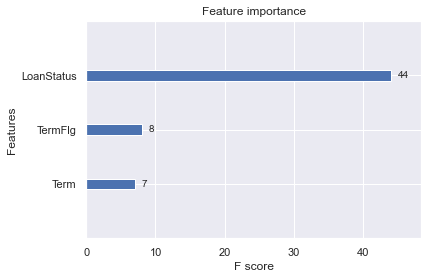

In [18]:
# 重要度の可視化
xgb.plot_importance(model,max_num_features=20)

In [19]:
# モデルの保存
with open("stack/" + featureName + "_" + modelName + '_model.pickle', mode='wb') as f:
    pickle.dump(model, f)

### 提出用データの予測/作成

In [20]:
# 予測データの取得
with open('data/dataset/raw/test_data.pickle','rb') as f:
    test_data = pickle.load(f)

In [21]:
# データ形式変換
# pred_data=pred_data.fillna(pred_data.mean())
test_data = xgb.DMatrix(test_data)

ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.Borrower, City, State, Bank, BankState, ApprovalDate, ApprovalFY, RevLineCr, LowLoan, DisbursementDate, DisbursementGross, BalanceGross, LoanAmount, GuaranteedLoan

In [ ]:
# モデルの保存
with open("data/dataset/test/" + featureName + "_" + modelName + '_model.pickle', mode='wb') as f:
    pickle.dump(model, f)